In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import gamma


In [2]:
def plot_gamma_distribution(alpha, scale, loc=0):
    """
    Plot a histogram of a gamma distribution with specified parameters.
    
    Parameters:
    -----------
    alpha : float
        Shape parameter of the gamma distribution
    scale : float 
        Scale parameter of the gamma distribution
    loc : float, optional (default=0)
        Location parameter of the gamma distribution
    """
    # Generate random samples from gamma distribution
    samples = gamma.rvs(alpha, scale=scale, loc=loc, size=10000)
    # Smallest sample
    smallest_sample = np.min(samples)
    # Largest sample
    largest_sample = np.max(samples)
    # Mean of the samples
    mean_of_samples = np.mean(samples)
    # Mode of the samples
    mode = gamma.ppf(0.5, alpha, scale=scale, loc=loc)

    # Create the plots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(4, 6))
    
    # Plot histogram and PDF
    ax1.hist(samples, bins=50, density=True, alpha=0.7, color='skyblue', edgecolor='black')
    x = np.linspace(smallest_sample, largest_sample, 100)
    pdf = gamma.pdf(x, alpha, scale=scale, loc=loc)
    ax1.plot(x, pdf, 'r-', lw=2, label='PDF')
    ax1.set_title(f'Gamma Distribution (α={alpha:.2f}, β={scale:.2f}, loc={loc:.2f})\n{smallest_sample:.2f} ± {largest_sample:.2f}. Mean: {mean_of_samples:.2f}, Mode: {mode:.2f}')
    ax1.set_xlabel('Value')
    ax1.set_ylabel('Density')
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.legend()
    
    # Plot CDF
    cdf = gamma.cdf(x, alpha, scale=scale, loc=loc)
    ax2.plot(x, cdf, 'b-', lw=2)
    ax2.set_title('Cumulative Distribution Function')
    ax2.set_xlabel('Value')
    ax2.set_ylabel('Probability')
    ax2.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()


In [3]:
def solve_parameters(t_low: float, t_high: float, loc: float):
    # theta = (t_high - t_low) / (2 * np.sqrt(alpha))
    # loc = (t_low + t_high) / 2 - alpha * theta 
    alpha = ((t_low + t_high - 2*loc) / (t_high - t_low))**2
    theta = (t_high - t_low)**2 / (2 * (t_low + t_high - 2*loc))
    return alpha, theta, loc



## Test

In [4]:
alpha, theta, loc = solve_parameters(1.0, 2.0, loc = 0.75)
print(f'alpha: {alpha}, theta: {theta}, loc: {loc}')


alpha: 2.25, theta: 0.3333333333333333, loc: 0.75


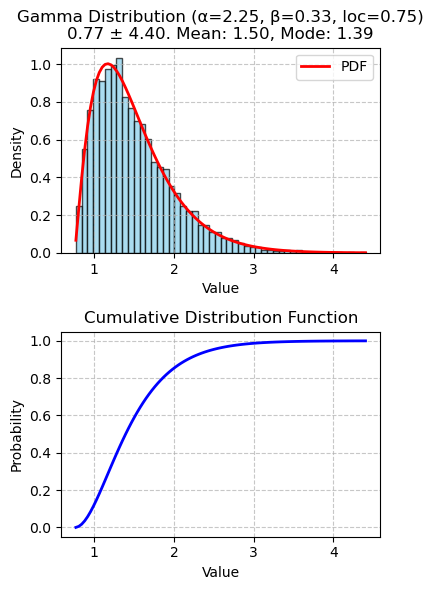

In [5]:
plot_gamma_distribution(alpha, theta, loc)


## Short-haul to Short-haul

alpha: 1.9599999999999997, theta: 0.17857142857142858, loc: 0.65


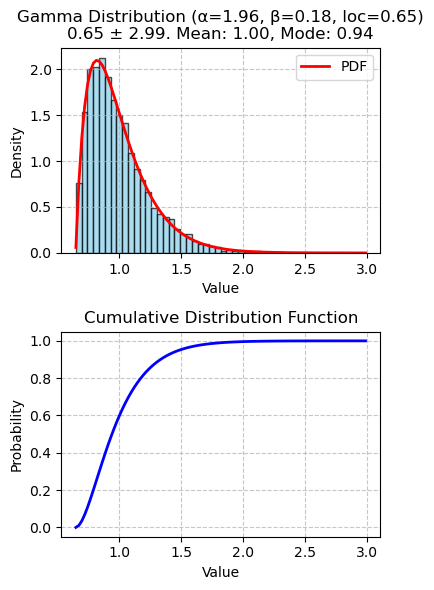

In [6]:
alpha, theta, loc = solve_parameters(t_low = 0.75, t_high = 1.25, loc = 0.65)
print(f'alpha: {alpha}, theta: {theta}, loc: {loc}')
plot_gamma_distribution(alpha, theta, loc)


## Short-haul to Long-haul

alpha: 2.5599999999999987, theta: 0.15625000000000003, loc: 1.85


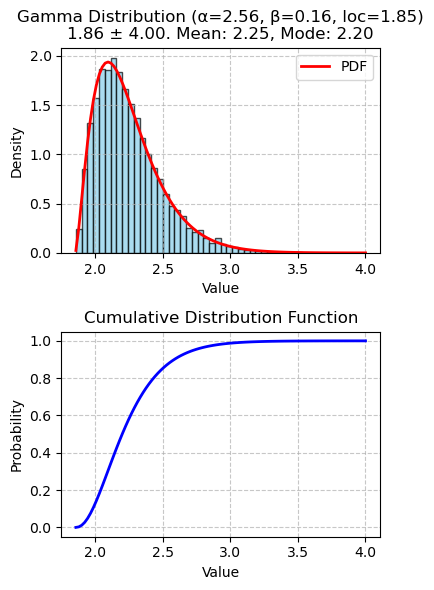

In [7]:
alpha, theta, loc = solve_parameters(t_low = 2.0, t_high = 2.5, loc = 1.85)
print(f'alpha: {alpha}, theta: {theta}, loc: {loc}')
plot_gamma_distribution(alpha, theta, loc)


## Long-haul to Short-haul


alpha: 4.456790123456792, theta: 0.10657894736842101, loc: 1.25


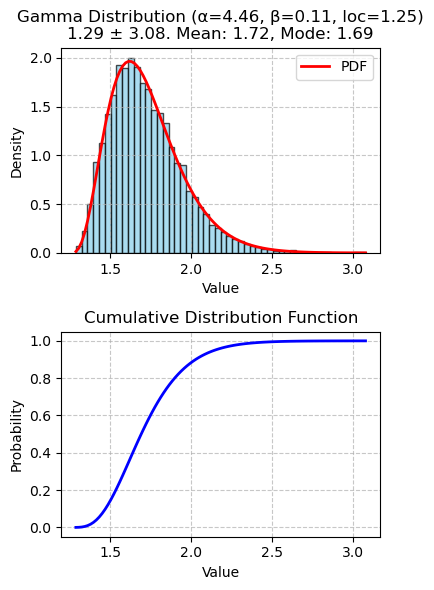

In [8]:
alpha, theta, loc = solve_parameters(t_low = 1.5, t_high = 1.95, loc = 1.25)
print(f'alpha: {alpha}, theta: {theta}, loc: {loc}')
plot_gamma_distribution(alpha, theta, loc)


## Long-haul to Long-haul


alpha: 4.0, theta: 0.25, loc: 2.25


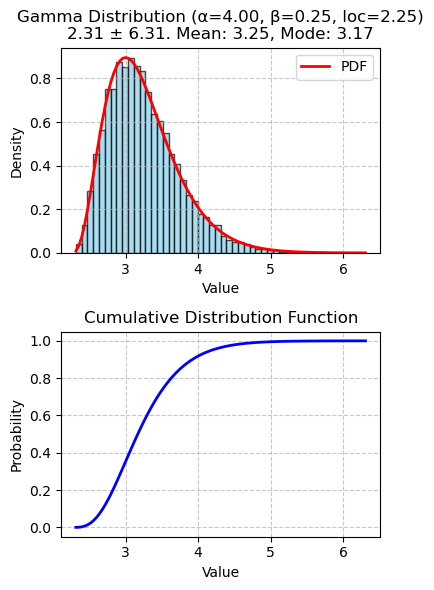

In [9]:
alpha, theta, loc = solve_parameters(t_low = 2.75, t_high = 3.75, loc = 2.25)
print(f'alpha: {alpha}, theta: {theta}, loc: {loc}')
plot_gamma_distribution(alpha, theta, loc)


# Cost matrix computation

One can run `8_linkage_infer.py` to compute the cost matrix for a given airline.


# Cost matrix visualization


In [10]:
S_CDG_AF = np.load("score_matrix_cdg_af.npy")

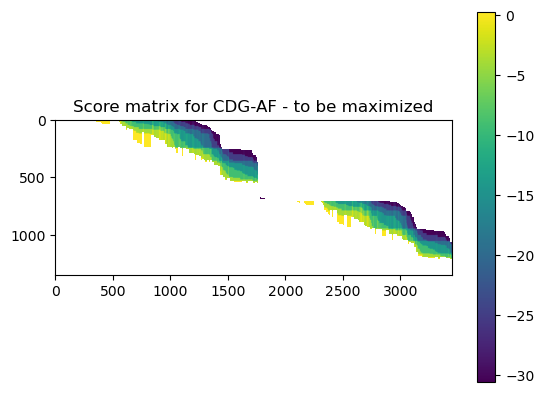

In [11]:
plt.imshow(S_CDG_AF)
plt.colorbar()
plt.title("Score matrix for CDG-AF - to be maximized")
plt.show()

In [14]:
import numpy as np
import pulp

# -------------------------------
# 1. Define the Data
# -------------------------------

L_b = S_CDG_AF.copy()
L_b[np.isneginf(L_b)] = -1e6
n = L_b.shape[0]
m = L_b.shape[1]


# The maximum number of matches is min(n, m)
max_matches = min(n, m)
lambda_penalty = 2000

# -------------------------------
# 2. Build the Optimization Model with PuLP
# -------------------------------
print(f'Building the optimization model with PuLP...')

# Create the problem instance: we want to minimize the total cost.
prob = pulp.LpProblem("StochasticAssignment", pulp.LpMaximize)

# Create the decision variables:
# x[i][j] == 1 if arrival i is matched to departure j, 0 otherwise.
# We'll use a dictionary of PuLP binary variables.
x = {}
from tqdm import tqdm
for i in tqdm(range(n), desc="Creating decision variables"):
    for j in range(m):
        x[(i, j)] = pulp.LpVariable(f"x_{i}_{j}", cat="Binary")

# Create the slack variable s to penalize "lazy assignments"
s = pulp.LpVariable("s", lowBound=0, cat="Continuous")

# -------------------------------
# 3. Set the Objective Function
# -------------------------------
print(f'Setting the objective function...')
# Minimize total cost sum_{i,j} L_b(i,j) * x_{ij}
prob += pulp.lpSum(L_b[i, j] * x[(i, j)] for i in range(n) for j in range(m)) - lambda_penalty * s, "TotalCost"

# -------------------------------
# 4. Add the Constraints
# -------------------------------
print(f'Adding the constraints...')
# (a) Each arrival (row) is matched to at most one departure.
for i in tqdm(range(n), desc="Adding arrival constraints"):
    prob += pulp.lpSum(x[(i, j)] for j in range(m)) <= 1, f"Arrival_{i}_Constraint"

# (b) Each departure (column) is matched to at most one arrival.
for j in tqdm(range(m), desc="Adding departure constraints"):
    prob += pulp.lpSum(x[(i, j)] for i in range(n)) <= 1, f"Departure_{j}_Constraint"

# (c) Total number of matches must equal min(n, m).
# prob += pulp.lpSum(x[(i, j)] for i in range(n) for j in range(m)) == max_matches, "TotalMatchesConstraint"

# Constraint: Total number of assignments plus slack equals min(n, m)
prob += pulp.lpSum(x[(i,j)] for i in range(n) for j in range(m)) + s == max_matches, "Lazy_Assignments"

# -------------------------------
# 5. Solve the Problem
# -------------------------------
import datetime
print(f'Solution started at {datetime.datetime.now()}')

solver = pulp.PULP_CBC_CMD(msg=True,  # Enable detailed messages
                          options=['printingOptions', 'all'])  # Show all printing options

result_status = prob.solve(solver)

print("Solver Status:", pulp.LpStatus[result_status])
print("Objective Value:", pulp.value(prob.objective))
# -------------------------------
# 6. Extract the Results
# -------------------------------
assignments = []
for i in range(n):
    for j in range(m):
        # If the variable x[(i,j)] is 1, then arrival i is matched with departure j.
        if pulp.value(x[(i, j)]) > 0.5:
            assignments.append((i, j))
            print(f"Arrival {i} is assigned to Departure {j} with cost {L_b[i, j]:.4f}")

print("\nTotal number of assignments:", len(assignments))
print(f'Maximum possible assignments: {max_matches}')

Building the optimization model with PuLP...


Creating decision variables: 100%|█████████████████████████████████████████████████| 1348/1348 [00:12<00:00, 111.61it/s]


Setting the objective function...
Adding the constraints...


Adding departure constraints: 100%|████████████████████████████████████████████████| 3449/3449 [00:13<00:00, 255.55it/s]


Solution started at 2025-02-05 00:02:07.697418
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/user/mambaforge/envs/env/lib/python3.11/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/1edab9c222ee47f393c75cb51fb18fd7-pulp.mps -max -printingOptions -all -timeMode elapsed -branch -printingOptions all -solution /tmp/1edab9c222ee47f393c75cb51fb18fd7-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 4803 COLUMNS
At line 27900318 RHS
At line 27905117 BOUNDS
At line 32554370 ENDATA
Problem MODEL has 4798 rows, 4649253 columns and 13947757 elements
Coin0008I MODEL read with 0 errors
printingOptions has value normal
Multiple matches for all - possible completions:
allC(ommands)
allow(ableGap)
allS(lack)
Option for timeMode changed from cpu to elapsed
Continuous objective value is -419228 - 8.99 seconds
Cgl0004I processed model has 4236 rows, 635437 columns (635436 integer (635436 of which binary)) and 1906309 ele